## Setup

First we load the necessary python packages and initialize variables

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import core_compute as cc
import core_plot as cp
import scipy.stats as ss

sns.set(color_codes=True)
D = {}
D['wrt_file'] = 'log.txt'
D['outname'] = 'example_0'

## Data generation

Create a true model (defined by **param_true**) and generate some sythetic data from it:

In [2]:
np.random.seed(3)
D['param_true'] = np.array([1, 1, 0.05])

npts = 10
D['Tt'] = np.sort(ss.uniform.rvs(loc=0, scale=1, size=npts))
Aerr = ss.norm.rvs(loc=0, scale=D['param_true'][2], size=npts)
D['At'] = D['param_true'][0] + D['param_true'][1]*D['Tt'] + Aerr
D['It'] = np.zeros(D['Tt'].shape)
D['At'][1] += 0.5
D['name_list'] = ['synthetic data']

Let's plot the true model and the synthetic data points:

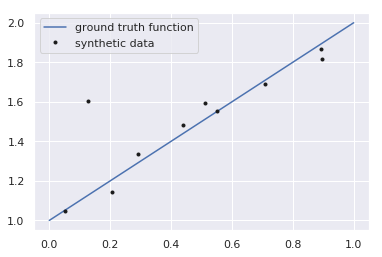

In [3]:
Tplt = np.linspace(0, 1, 100)
Aplt = D['param_true'][0] + D['param_true'][1]*Tplt
plt.plot(Tplt, Aplt, 'b-',
        label='ground truth function')
plt.plot(D['Tt'], D['At'], 'k.', label=D['name_list'][0])
plt.legend()

## Define the likelihood

In other words, define the probability that the the data is observed given a model with specified parameters. We use a log-probability because this causes fewer computational problems.

In [4]:
def likelihood(param, D):

    # make sure the likelihood is -inf if the scale <= 0
    if param[-1] <= 0:
        return -np.inf

    prob = ss.norm.logpdf(
        feval(param, D['Tt'], D), loc=D['At'], scale=param[-1]).sum()
    # prob = ss.t.logpdf(
    #     feval(param, D['Tt'], D), df=3, loc=D['At'], scale=param[-1]).sum()
    
    if np.isnan(prob):
        return -np.inf

    return prob

D['likelihood'] = likelihood

## Hypothesize a model

Define a polynomial order of interest and name the model parameters (**theta_x**) and a parameter to capture the spread of the data around the model (**scale**).

In [5]:
def feval(param, T, D):
    A = np.zeros((np.atleast_2d(param)[..., 0]*T).shape)
    for ii in range(D['order']+1):
        A += np.atleast_2d(param)[..., ii]*T**ii
    return A

In [6]:
D['order'] = 1
D['pname'] = ['theta' + str(ii) for ii in range(D['order']+1)] + ['scale']
D['nparam'] = len(D['pname'])
print('parameter names:', D['pname'])

parameter names: ['theta0', 'theta1', 'scale']


## Define the prior distributions

* **distV** vector defining distribution type for each parameter
* **locV** vector defining location parameter of each distribution
* **scaleV** vector defining scale parameter of each distribution

In [7]:
D['distV'] = (D['order']+2)*['uniform']
D['locV'] = (D['order']+1)*[-8] + [0]
D['scaleV'] = (D['order']+1)*[16] + [1]
D['cV'] = (D['order']+2)*[None]
D['dim'] = len(D['distV'])

print('Distribution types:', D['distV'])
print('Location parameters:', D['locV'])
print('Scale parameters:', D['scaleV'])

Distribution types: ['uniform', 'uniform', 'uniform']
Location parameters: [-8, -8, 0]
Scale parameters: [16, 16, 1]


## Perform Bayesian inference

Choose a sampler type and perform the numerical Bayesian inference.

In [8]:
sampler = 'multinest'

if sampler == 'multinest':

    D = cc.sampler_multinest(D)
    flattrace = D['rawtrace']

elif sampler == 'kombine':
    
    D = cc.sampler_kombine(D)
    trace = D['rawtrace'][:, -D['nlinks']:, :]
    flattrace = trace.reshape((D['nlinks']*D['nwalkers'], len(D['pname'])))
    
    cp.plot_chains(D['rawtrace'], D['nlinks'], D['pname'])
    
print('log marginal likelihood (model evidence): ',
      np.round(D['lnZ'], 3), '+/-', np.round(D['dlnZ'], 3))

  analysing data from chains/example_0-.txt
(4057, 3)
log marginal likelihood (model evidence):  -4.921 +/- 0.105


## Analyze posterior parameter distribution

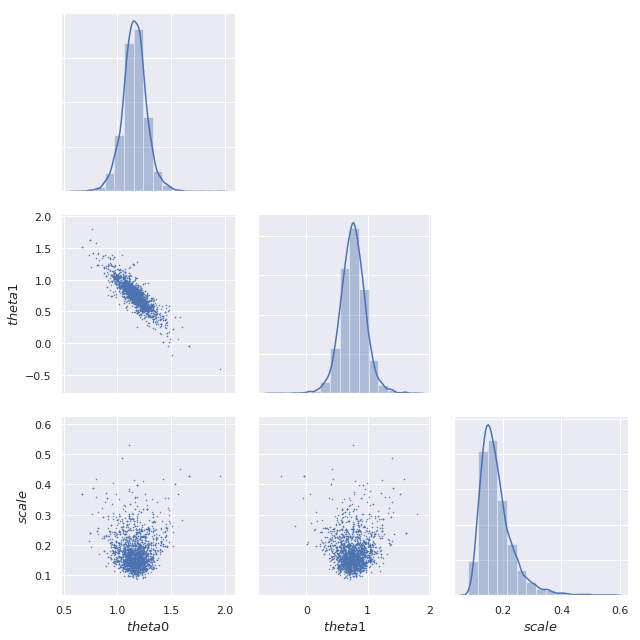

In [9]:
# cp.plot_cov(flattrace, D['pname'], param_true=D['param_true'])
cp.plot_cov(flattrace, D['pname'])

## Analyze posterior prediction and uncertainty

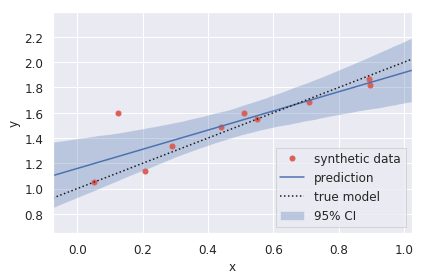

In [10]:
cp.plot_prediction(flattrace, D['name_list'], D['Tt'], D['At'], D['It'],
                   feval, D, param_true=D['param_true'])